# 500-queen

In this assignment, you need to use efficient backtracking to solve 500-queen problem. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
class CSP():
    """This class describes finite-domain Constraint Satisfaction Problems.
    A CSP is specified by the following inputs:
        variables   A list of variables; each is atomic (e.g. int or string).
        domains     A dict of {var:[possible_value, ...]} entries.
        neighbors   A dict of {var:[var,...]} that for each variable lists
                    the other variables that participate in constraints.
        constraints A function f(A, a, B, b) that returns true if neighbors
                    A, B satisfy the constraint when they have values A=a, B=b

    In the textbook and in most mathematical definitions, the
    constraints are specified as explicit pairs of allowable values,
    but the formulation here is easier to express and more compact for
    most cases (for example, the n-Queens problem can be represented
    in O(n) space using this notation, instead of O(n^4) for the
    explicit representation). In terms of describing the CSP as a
    problem, that's all there is.

    However, the class also supports data structures and methods that help you
    solve CSPs by calling a search function on the CSP. Methods and slots are
    as follows, where the argument 'a' represents an assignment, which is a
    dict of {var:val} entries:
        assign(var, val, a)     Assign a[var] = val; do other bookkeeping
        unassign(var, a)        Do del a[var], plus other bookkeeping
        nconflicts(var, val, a) Return if constaints are satisfied for var=val with assigned variables.
    """

    def __init__(self, variables, domains, neighbors, constraints):
        """Construct a CSP problem. If variables is empty, it becomes domains.keys()."""
        variables = variables or list(domains.keys())
        self.variables = variables
        self.domains = domains
        self.neighbors = neighbors
        self.constraints = constraints

    def assign(self, var, val, assignment):
        """Add {var: val} to assignment; Discard the old value if any."""
        assignment[var] = val

    def unassign(self, var, assignment):
        """Remove {var: val} from assignment.
        DO NOT call this if you are changing a variable to a new value;
        just call assign for that."""
        if var in assignment:
            del assignment[var]

    def conflict(self, var, val, assignment):
        """Return if constaints are satisfied for var=val with assigned variables."""

        # Subclasses may implement this more efficiently
        def conflict_var(var2):
            return var2 in assignment and not self.constraints(var, val, var2, assignment[var2])

        return 0 != np.sum(conflict_var(v) for v in self.neighbors[var])

    # These are for constraint propagation

    def prune(self, var, value, removals):
        """Rule out var=value."""
        self.domains[var].remove(value)
        if removals is not None:
            removals.append((var, value))

    def restore(self, removals):
        """Undo prune and all inferences from it."""
        for B, b in removals:
            self.domains[B].append(b)


In [4]:
def queen_constraint(A, a, B, b):
    """Constraint is satisfied (true) if A, B are really the same variable,
    or if they are not in the same row, down diagonal, or up diagonal."""
    # All (i,j) on same diagonal / have same sum i+j, from top left corner 0 to bottom right corner 2n-2
    # All (i,j) on same diagonal \ have same difference i-j, from bottom left corner n-1 to top right corner -(n-1) 
    return A == B or (a != b and A + a != B + b and A - a != B - b)

In [5]:
class NQueensCSP(CSP):
    """
    Make a CSP for the nQueens problem.
    Think of placing queens one per column, from left to right.
    That means position (x, y) represents (var, val) in the CSP.
    """

    def __init__(self, n):
        """Initialize data structures for n Queens."""
        domains = {}
        neighbors = {}
        for i in range(n):
            domains[i] = list(range(n))
            neighbors[i] = list(range(n))
        CSP.__init__(self, list(range(n)), domains,
                     neighbors, queen_constraint)

    def display(self, assignment):
        """Print the queens for n < 30."""
        n = len(assignment)
        board = np.array([2 * int((i + j) % 2) for j in range(n) for i in range(n)]).reshape((n, n))
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(111)
        ax.set_title('{} Queens'.format(n))
        plt.imshow(board, cmap='binary', interpolation='nearest')
        # NQueensCSP gives a solution as a dictionary
        if isinstance(assignment, dict):
            for (k, v) in assignment.items():
                plt.annotate('Q', (k,v), color='red', size=200/n)

        fig.tight_layout()
        plt.show()
        
    def verify(self, assigment):
        """Verify if assignment reaches a solution."""
        for var in self.variables:
            if var not in assignment or self.conflict(var, assignment[var], assignment):
                print("Solution is wrong!\n")
                return 
        print("Solution is correct!\n")

In [6]:
def first_unassigned_variable(csp, assignment):
    """
    The default variable order.
    Return the first variable in the list of unassigned variables. 
    """
    for var in csp.variables:
        if var not in assignment:
            return var
    return None # if all variables have been assigned. 

In [7]:
def no_inference(csp, var, value, assignment, removals):
    """The default inference.
    """
    return True

In [8]:
def backtracking_search(csp, select_unassigned_variable=first_unassigned_variable,
                        inference=no_inference):
    """backtracking"""

    def backtrack(assignment):
        # assignment is a dictionary - variable:value or var:val. 
        if len(assignment) == len(csp.variables):
            return assignment
        var = select_unassigned_variable(csp, assignment) # MRV or first unassigned variable
        for value in csp.domains[var]: # better if using LCV here
            if not csp.conflict(var, value, assignment): # if no conflict 
                csp.assign(var, value, assignment) 
                removals = [] # values removed from unassigned variables during the forward checking or other inferences. 
                # True if there is no empty domain
                if inference(csp, var, value, assignment, removals): # better if using AC-3
                    result = backtrack(assignment)
                    if result is not None:
                        return result
                csp.restore(removals)
        csp.unassign(var, assignment)
        return None

    result = backtrack({})
    return result

### Run backtracking with default setting:

- Choose first unassigned variable.
- Choose first value in its domain. 
- Do not prune any values from domains of unassigned variables after assigning this variable. 

Solution is correct!



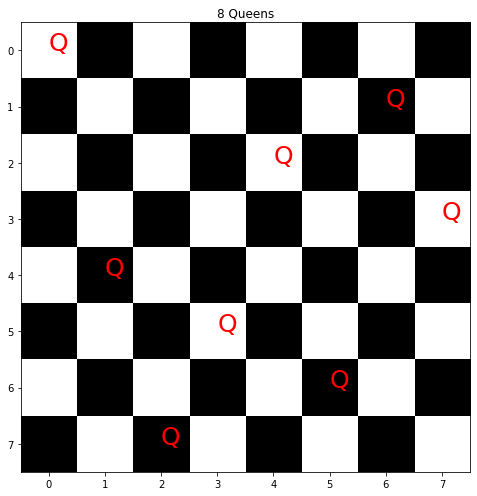

CPU times: total: 46.9 ms
Wall time: 94.4 ms


In [9]:
%%time
eight_queens = NQueensCSP(8) # Choose a number less or equal than 15. 
assignment = backtracking_search(eight_queens)
eight_queens.verify(assignment)
eight_queens.display(assignment)

### Run backtracking with forward checking:

- Choose first unassigned variable.
- Choose first value in its domain. 
- Prune values from domains of unassigned variables after assigning this variable using forward checking. 

In [10]:
def forward_checking(csp, var, value, assignment, removals):
    """Prune neighbor values inconsistent with var=value.
    
    Pseudocode:
    for every neighbor B of var
        if B is not assigned yet 
            check every value in current domain of B against value of var 
                if constraint is not satisified 
                    prune this value from B
            if domain of B becomes empty 
                return False
     return True
     """
    # Your code goes here:
    for neighbor in csp.neighbors[var]:
        if neighbor not in assignment:
            for val in csp.domains[neighbor]:
                if not queen_constraint(var, value, neighbor, val):
                    csp.prune(neighbor, val, removals)
            if not csp.domains[neighbor]:
                return False
    return True


For 20-queens, backtracking with forward checking should take less than five seconds to find a solution. 

In [11]:
%%time
eight_queens = NQueensCSP(20)  # Choose a number less or equal than 20. 
assignment = backtracking_search(eight_queens, first_unassigned_variable, forward_checking)
eight_queens.verify(assignment)
# eight_queens.display(assignment)

Solution is correct!

CPU times: total: 1.28 s
Wall time: 2.09 s


### Run backtracking with MRV and forward checking:

- Choose unassigned variable using MRV.
- Choose first value in its domain. 
- Prune values from domains of unassigned variables after assigning this variable using forward checking. 

In [24]:
def mrv(csp, assignment):
    """Minimum-remaining-values heuristic.
    Input: CSP of queen
           Current assignment. 
    Output: An unassigned variable with smallest domain. 
    """
    # Your code goes here: 
    smallest_domain = 501
    best_variable = None
    for var in csp.variables:
        if var in assignment:
            continue
        domain = csp.domains[var]
        if len(domain) < smallest_domain:
            smallest_domain = len(domain)
            best_variable = var
    return best_variable


For nqueens, the time that backtracking with MRV and forward checking needs to take to find a solution is:

| N of queens | Time   |   |   |   |
|-------------|--------|---|---|---|
| 20          | 10 ms  |   |   |   |
| 100         | 101 ms |   |   |   |
| 500         | 7.11 s  |   |   |   |

These runing time is measured on my Mac (MacBook Air (M1, 2020)).

You must run your code using 500 queens and take less than 10 seconds to find a solution. 

In [30]:
%%time
eight_queens = NQueensCSP(500)
assignment = backtracking_search(eight_queens, mrv, forward_checking)
# assignment = backtracking_search(eight_queens, first_unassigned_variable, forward_checking)
eight_queens.verify(assignment)
# eight_queens.display(assignment)

Solution is correct!

CPU times: total: 5.98 s
Wall time: 8.08 s
